In [1]:
%matplotlib inline

import numpy as np
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm.auto import tqdm
tqdm.pandas()
import scipy.stats as stats
import copy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)
warnings.simplefilter(action = 'ignore', category = DeprecationWarning)
warnings.simplefilter(action = 'ignore', category = UserWarning)
warnings.simplefilter(action = 'ignore', category = RuntimeWarning)
warnings.filterwarnings("ignore", message = "numpy.dtype size changed")
warnings.filterwarnings("ignore", message = "numpy.ufunc size changed")
pd.options.mode.chained_assignment = None

DEBUG = False

In [2]:
%%time

if DEBUG:
    videos = pl.read_parquet('../input/videos.parquet', n_rows = 10_000)
else: 
    videos = pl.read_parquet('../input/videos.parquet')
    
videos.shape

CPU times: user 7.81 s, sys: 8.24 s, total: 16 s
Wall time: 12.8 s


(34404561, 7)

In [3]:
videos.head(3)

video_id,video_title,channel_title,v_channel_reg_datetime,v_channel_type,v_category,v_pub_datetime
str,str,str,"datetime[ns, UTC]",str,str,"datetime[ns, UTC]"
"""video_6484084""","""Palia. Рыбалка…","""Gamer Diary""",2022-04-13 10:23:19 UTC,"""UGC""","""Видеоигры""",2023-09-18 20:04:10 UTC
"""video_1522415""","""Прощание пройд…","""pntuser290""",2022-09-05 09:32:50 UTC,"""UGC""","""Разное""",2023-06-03 23:04:32 UTC
"""video_642363""","""#ДОБРОЛАП. ТВО…","""Зоомагазин Чет…",2022-04-13 08:07:35 UTC,"""UGC""","""Лайфстайл""",2022-04-15 14:18:15 UTC


# Типы данных и количество пропущеных значений

In [4]:
for u, t in zip(videos.columns, videos.dtypes):
    print(u, 'dtype:', t, 'count NaN:', videos.filter(pl.col(u).is_null()).shape[0])

video_id dtype: Utf8 count NaN: 0
video_title dtype: Utf8 count NaN: 0
channel_title dtype: Utf8 count NaN: 0
v_channel_reg_datetime dtype: Datetime(time_unit='ns', time_zone='UTC') count NaN: 0
v_channel_type dtype: Utf8 count NaN: 0
v_category dtype: Utf8 count NaN: 0
v_pub_datetime dtype: Datetime(time_unit='ns', time_zone='UTC') count NaN: 257


In [5]:
temp = videos['video_id'].value_counts().sort(by = ['counts'], descending = True)
temp

video_id,counts
str,u32
"""video_15007798…",2
"""video_11067121…",2
"""video_15599346…",2
"""video_5775682""",2
"""video_15600679…",2
"""video_15599477…",2
"""video_13535025…",2
"""video_7168905""",2
"""video_7338201""",2


In [6]:
# Самое популяроное видео

In [7]:
temp['video_id'][0]

'video_15007798'

In [8]:
videos.filter(pl.col('video_id') == temp['video_id'][0])['video_title'][0]

'20231114-03 Natural Spiny Oyster and Turquoise  Beads 16 Inches Long Great quality Beads'

# Категории с наибольшим количеством просмотров

In [9]:
temp = videos['v_category'].value_counts().sort(by = ['counts'], descending = True)

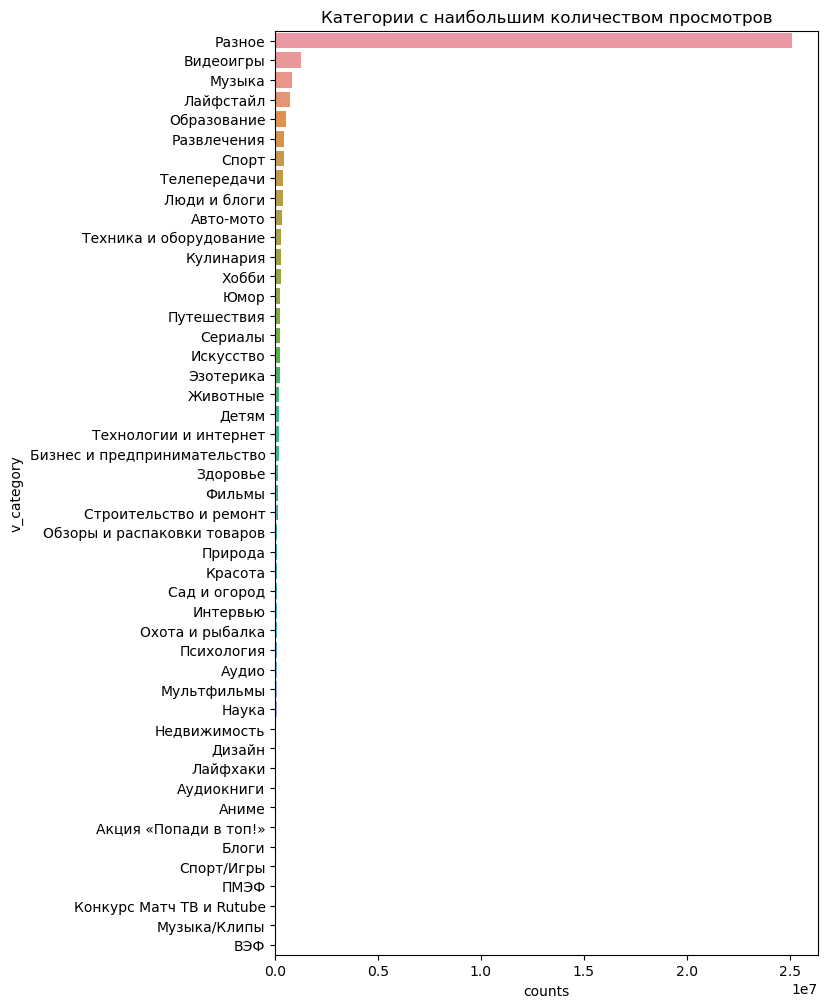

In [10]:
temp = temp.to_pandas()
temp['v_category'] = temp['v_category'].astype(str)
temp.sort_values(by = ['counts'], ascending = False, inplace = True)

plt.figure(figsize = (7, 12))
plt.title("Категории с наибольшим количеством просмотров")
sns.barplot(x = 'counts', y = 'v_category', data = temp[:50]);

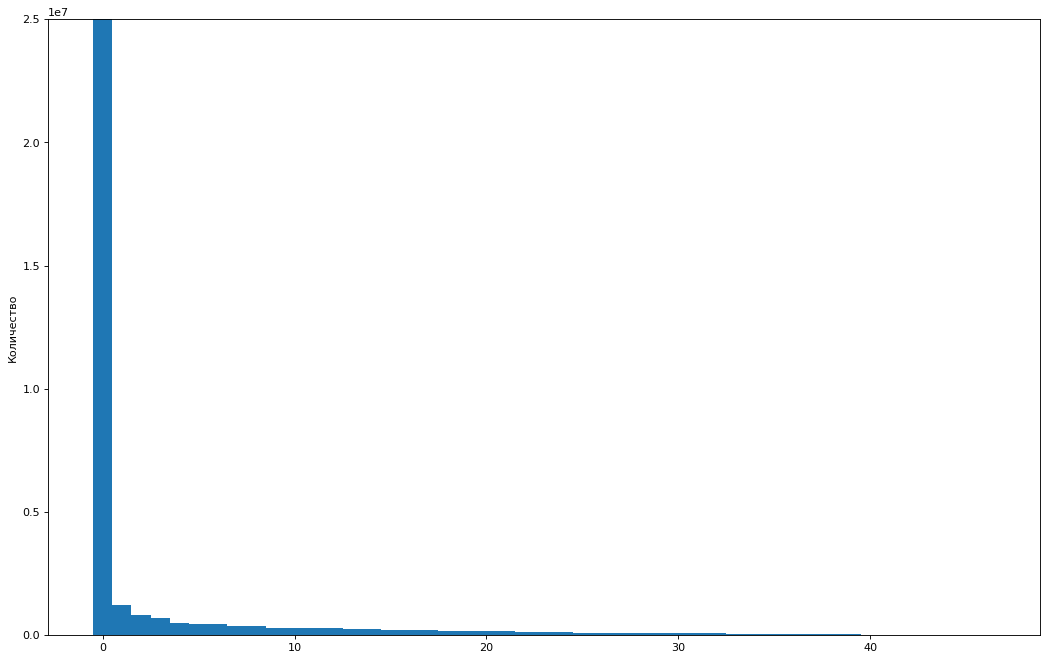

In [11]:
plt.figure(figsize = (16, 10), dpi = 80)

n = len(temp['v_category'].unique()) + 1
all_colors = list(plt.cm.colors.cnames.keys())

c = random.choices(all_colors, k = n)

plt.bar(range(temp.shape[0]), temp['counts'], width = 1)

plt.ylabel('Количество')
plt.ylim(0, 2.5e7)
plt.show()

In [12]:
temp2 = temp[(temp['counts'] < temp['counts'].quantile(0.99))]

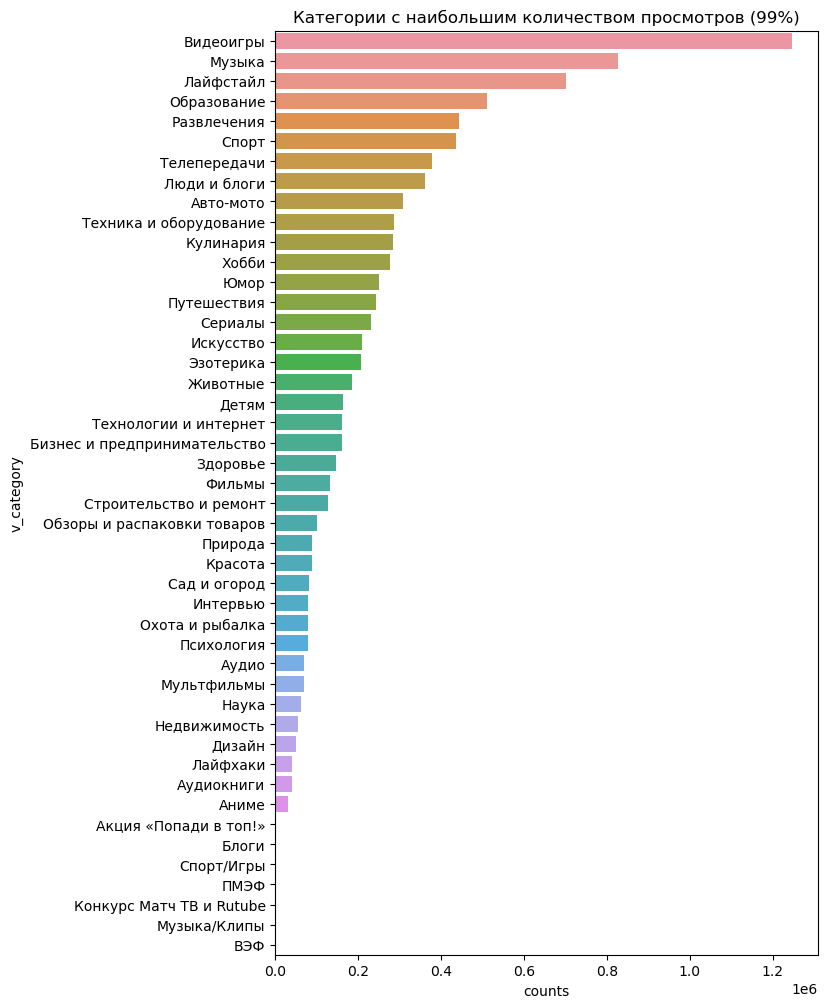

In [13]:
temp2['v_category'] = temp2['v_category'].astype(str)
temp2.sort_values(by = ['counts'], ascending = False, inplace = True)

plt.figure(figsize = (7, 12))
plt.title("Категории с наибольшим количеством просмотров (99%)")
sns.barplot(x = 'counts', y = 'v_category', data = temp2);

<Axes: >

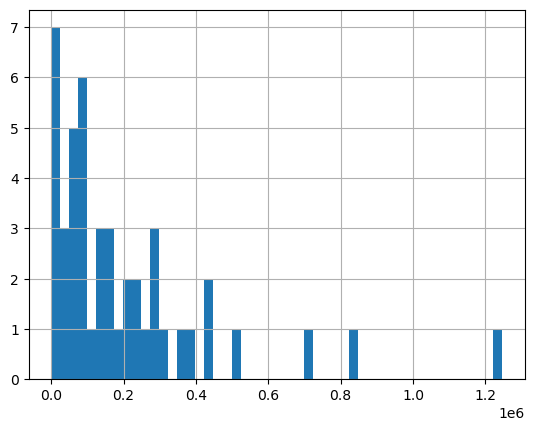

In [14]:
temp2['counts'].hist(bins = 50)

In [15]:
mean_value = np.round(temp['counts'].mean(), 2)
print('Средниее количество просмотров: ', mean_value)

Средниее количество просмотров:  732011.94


In [16]:
median_value = np.round(temp['counts'].median(), 2)
print('Медианное количество просмотров в категорях: ', median_value)

Медианное количество просмотров в категорях:  132757.0


In [17]:
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.98, 0.99]

for quantile in quantiles:
    percentile_value = temp['counts'].quantile(quantile)
    name = int(quantile * 100)
    print(f'{name}-й процентиль просмотров: ', int(percentile_value))

10-й процентиль просмотров:  812
20-й процентиль просмотров:  43358
30-й процентиль просмотров:  69753
40-й процентиль просмотров:  83547
50-й процентиль просмотров:  132757
60-й процентиль просмотров:  175783
70-й процентиль просмотров:  244987
80-й процентиль просмотров:  303654
90-й процентиль просмотров:  470475
98-й процентиль просмотров:  3155451
99-й процентиль просмотров:  14135170


In [18]:
temp = videos['v_channel_type'].value_counts().sort(by = ['counts'], descending = True)

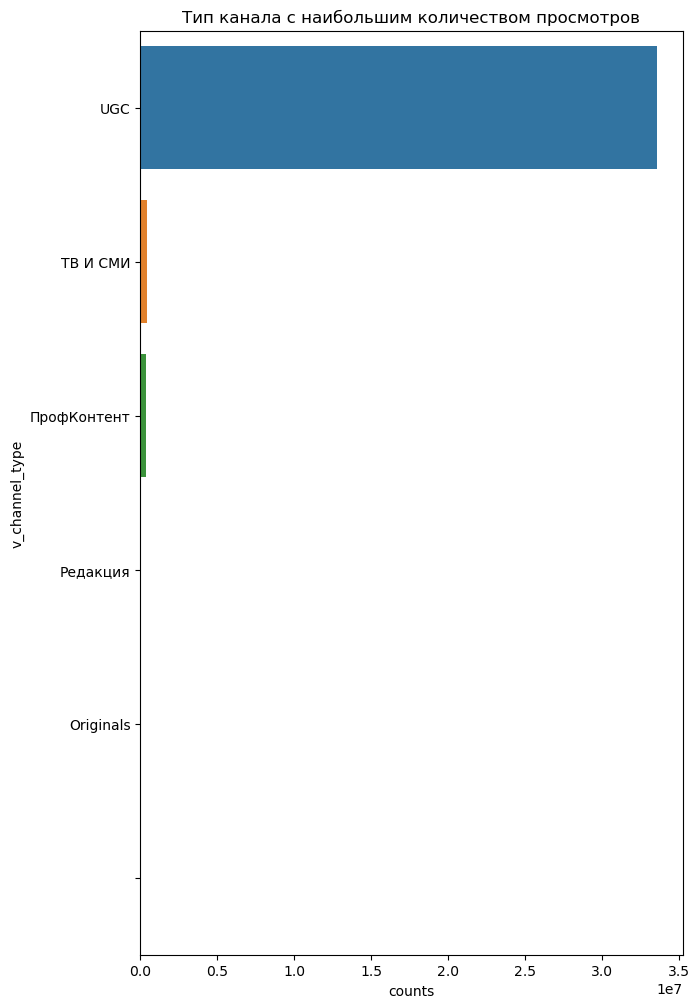

In [19]:
temp = temp.to_pandas()
temp['v_channel_type'] = temp['v_channel_type'].astype(str)
temp.sort_values(by = ['counts'], ascending = False, inplace = True)

plt.figure(figsize = (7, 12))
plt.title("Тип канала с наибольшим количеством просмотров")
sns.barplot(x = 'counts', y = 'v_channel_type', data = temp[:50]);

In [20]:
temp = videos['channel_title'].value_counts().sort(by = ['counts'], descending = True)

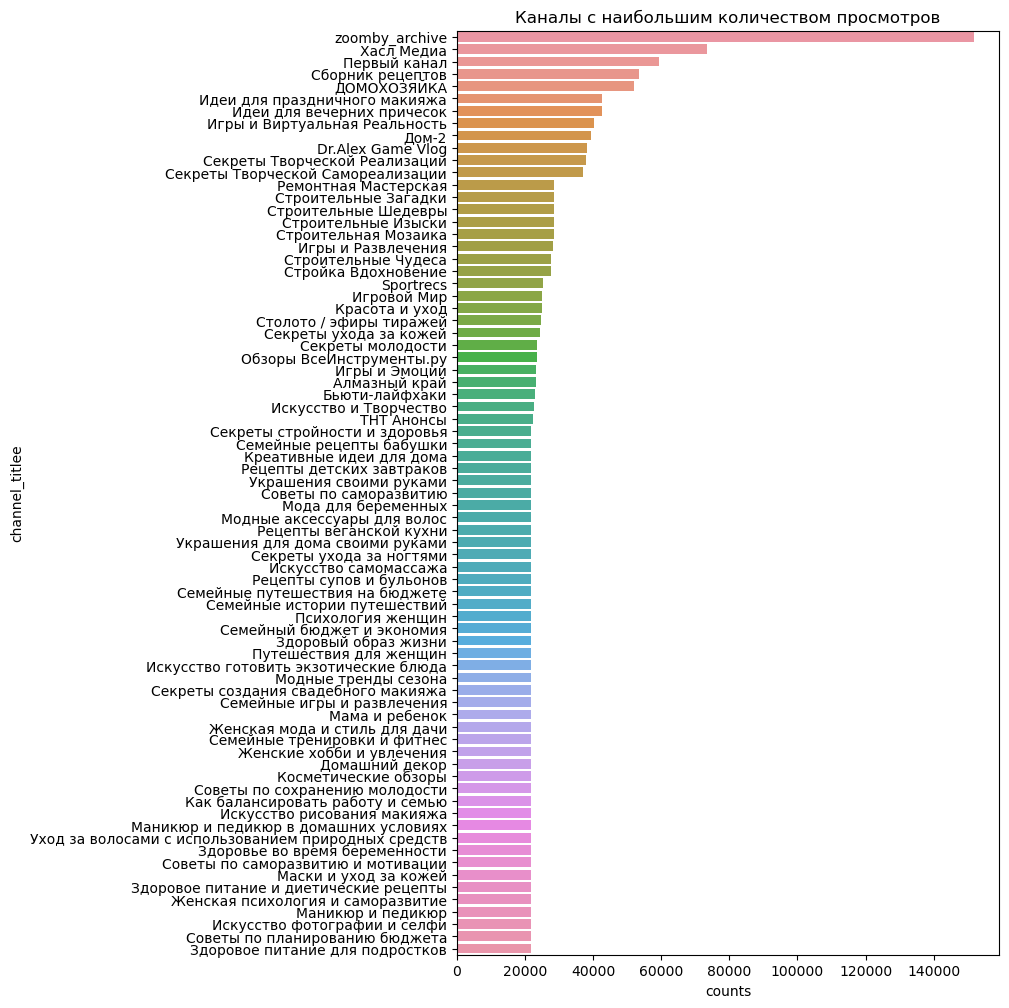

In [21]:
temp = temp.to_pandas()
temp['channel_titlee'] = temp['channel_title'].astype(str)
temp.sort_values(by = ['counts'], ascending = False, inplace = True)

plt.figure(figsize = (7, 12))
plt.title("Каналы с наибольшим количеством просмотров")
sns.barplot(x = 'counts', y = 'channel_titlee', data = temp[:75]);

In [22]:
temp = videos['video_title'].value_counts().sort(by = ['counts'], descending = True)
temp

video_title,counts
str,u32
"""""",57938
"""Без названия""",21247
"""Раскраска с Ма…",3722
"""World of Warcr…",3221
"""1""",1895
"""Мир танков""",1772
"""Смотри сегодня…",1522
"""китай.маньчжур…",1476
"""стандофф 2""",1396


In [23]:
videos = videos.with_columns(
    search_tag = pl.col('video_title') + ' ' + pl.col('channel_title') + ' ' + pl.col('v_category')
)

In [24]:
def length(struct):    
    return len(struct['search_tag'].split(' '))

videos = videos.with_columns([
    pl.struct(["search_tag"]).apply(length).alias('len')
])

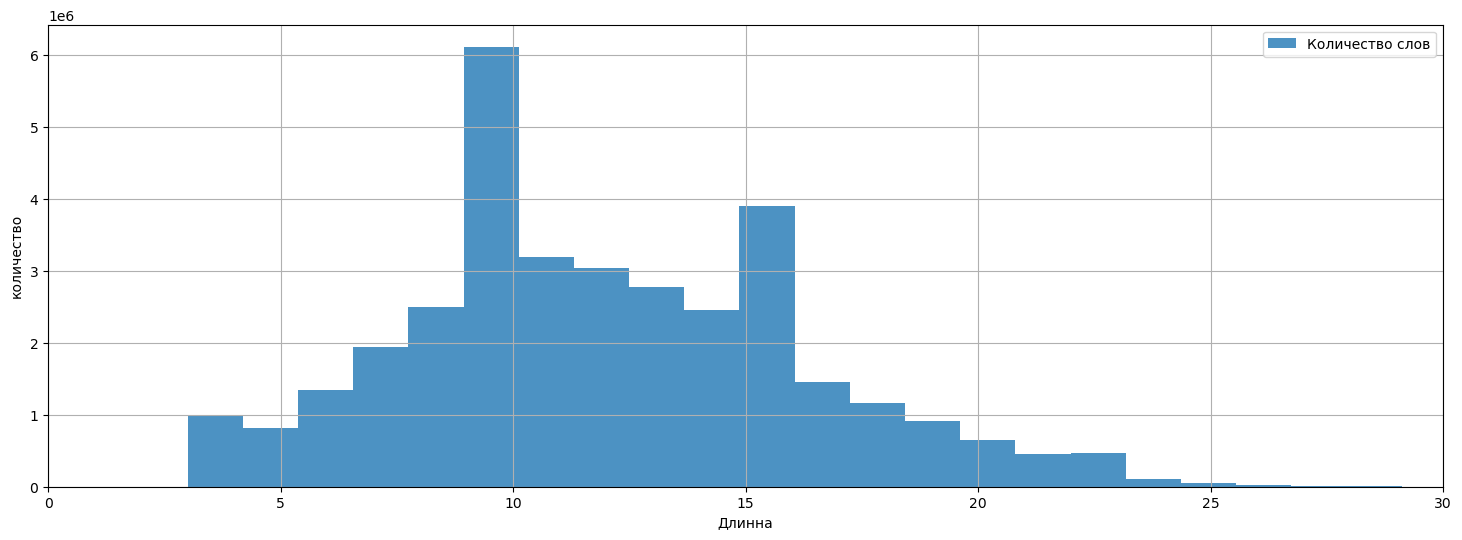

In [25]:
# Роспределение количества слов в запросе ('search_tag')

plt.rcParams['figure.figsize'] = (18, 6)
bins = 75
plt.hist(videos['len'], alpha = 0.8, bins = bins, label = 'Количество слов')
plt.xlabel('Длинна')
plt.ylabel('количество')
plt.legend(loc = 'upper right')
plt.xlim(0, 30)
plt.grid()
plt.show()

In [27]:
from nltk.corpus import stopwords

stopwords = stopwords.words('russian')
stopwords.append('разное')
stopwords.append('за')

In [28]:
def get_top_ngrams(corpus, ngram_range, n):
    vec = CountVectorizer(
        ngram_range = ngram_range, 
        #max_features = 10_000,
        stop_words = stopwords
    )
    vec.fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis = 0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
    
    return words_freq[:n]

<Axes: >

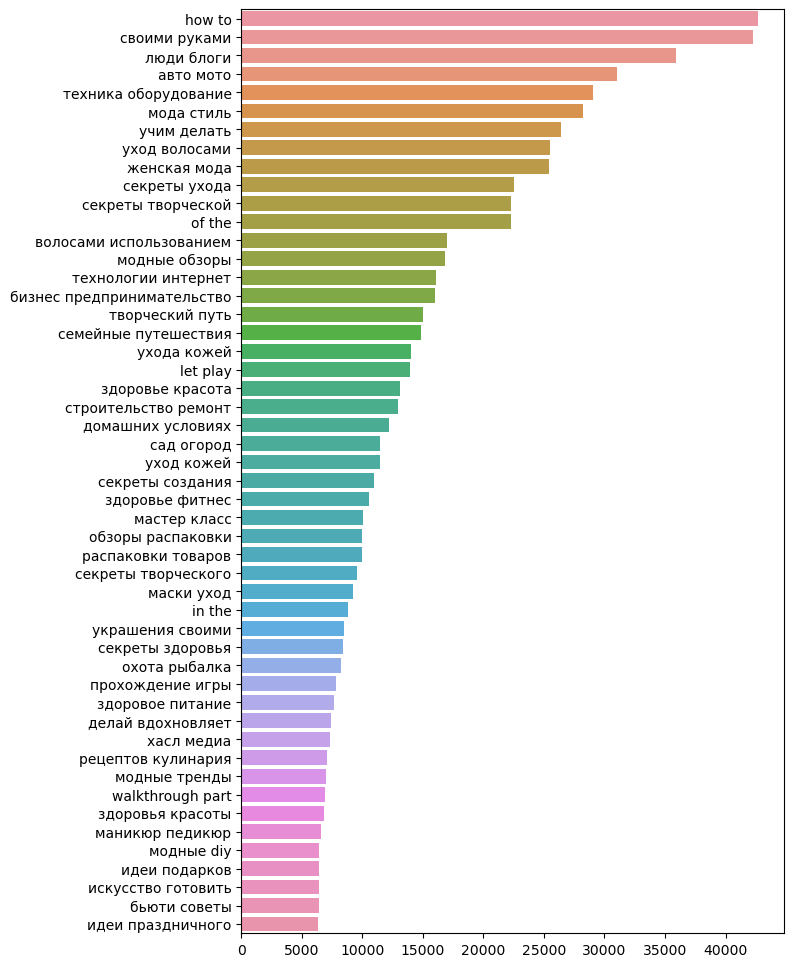

In [29]:
# Наиболее часто встречающиеся биграммы в запросе ('search_tag')

plt.figure(figsize = (7, 12))
top_bigrams = get_top_ngrams(videos['search_tag'], (2, 2), 50)
x, y = map(list, zip(*top_bigrams))
sns.barplot(x = y, y = x)

<Axes: >

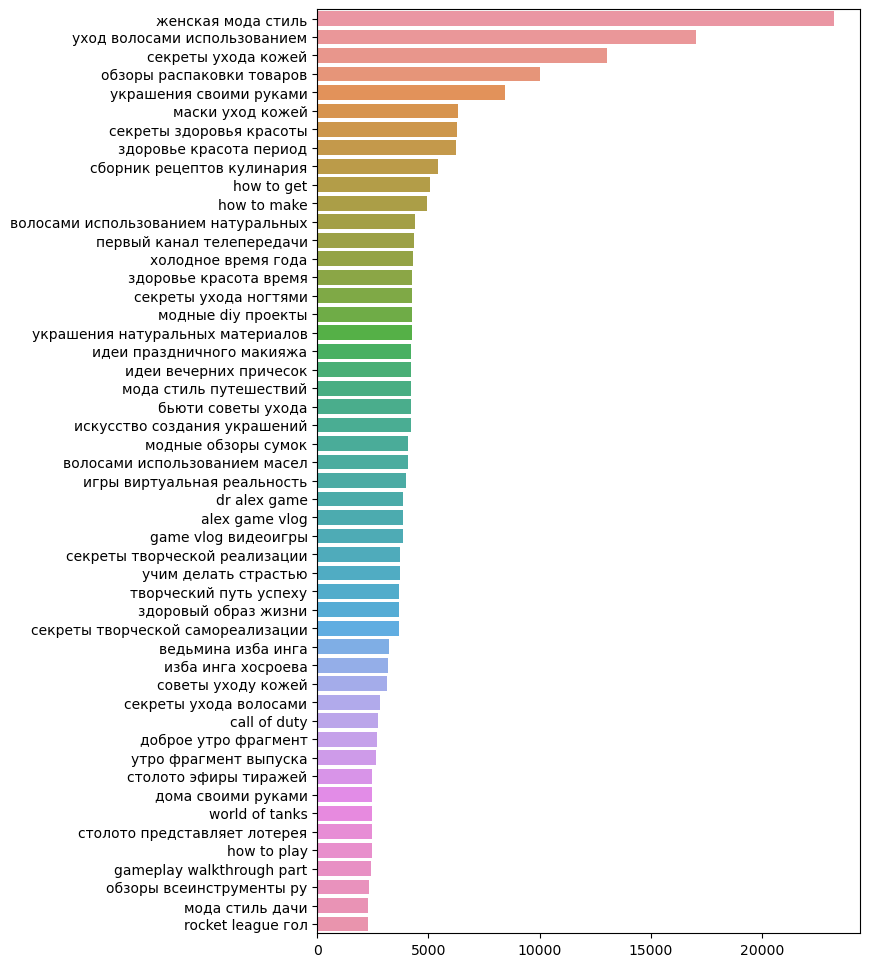

In [30]:
# Наиболее часто встречающиеся три-граммы в запросе ('search_tag')

plt.figure(figsize = (7, 12))
top_bigrams = get_top_ngrams(videos['search_tag'], (3, 3), 50)
x, y = map(list, zip(*top_bigrams))
sns.barplot(x = y, y = x)

<Axes: >

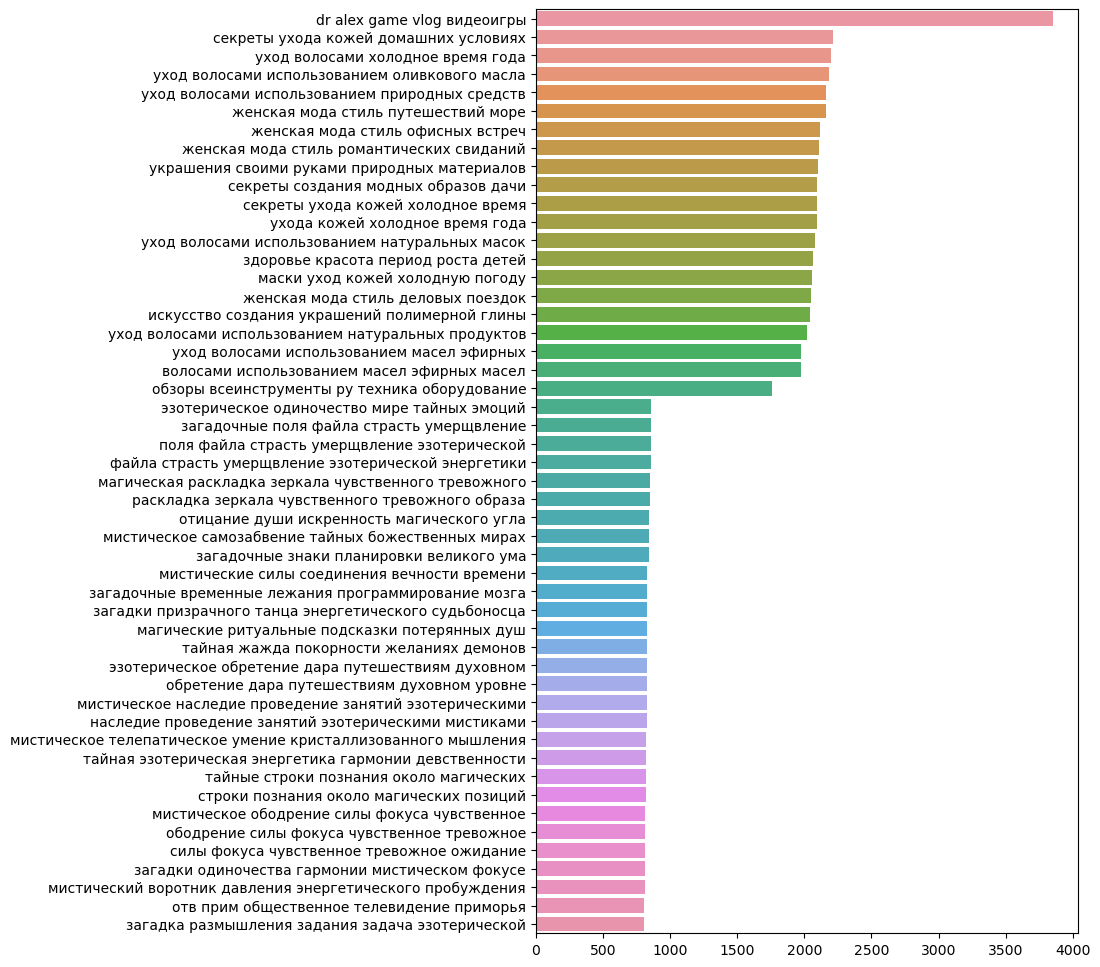

In [31]:
## Наиболее часто встречающиеся 5-граммы в запросе ('search_tag')

plt.figure(figsize = (7, 12))
top_bigrams = get_top_ngrams(videos['search_tag'], (5, 5), 50)
x, y = map(list, zip(*top_bigrams))
sns.barplot(x = y, y = x)